Investigate with real data how the amount of noise affects the qr and standard approaches to coherence analysis.

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import time

sys.path.append("../")
sys.path.append(os.path.join(os.path.dirname(""), os.pardir))
import coherence_analysis.utils as f

In [4]:
start_ch = 3100
nchannels = 2000
nsensors = 200

In [5]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083818.h5"
data, _ = f.load_brady_hdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

data = np.append(data, data2, axis=1)

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

# data = np.append(data, data2, axis=1)

data = np.append(data, data2[:, :10000], axis=1)
data = data[start_ch : nchannels + start_ch : int(nchannels / nsensors)]

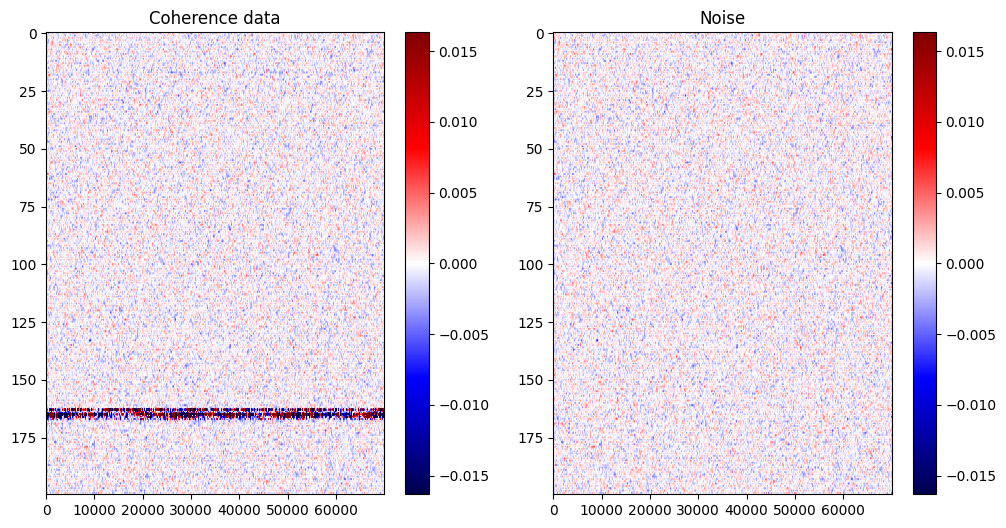

In [7]:
nr, nc = data.shape
noise = np.random.normal(scale=1, size=(nr, nc))
# normalize noise
noise = noise / np.linalg.norm(noise)
noise = noise * np.max(np.abs(data)) * 40
coherence_data = data + noise
# coherence_data.shape
vmin, vmax = np.quantile(
    data[10], [0.1, 0.999]
)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(
    coherence_data, aspect="auto", cmap="seismic", vmin=-vmax, vmax=vmax
)
plt.title("Coherence data")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(noise, aspect="auto", cmap="seismic", vmin=-vmax, vmax=vmax)
plt.title("Noise")
plt.colorbar()

In [8]:
# np.max(np.abs(data))
data.shape

(200, 70000)

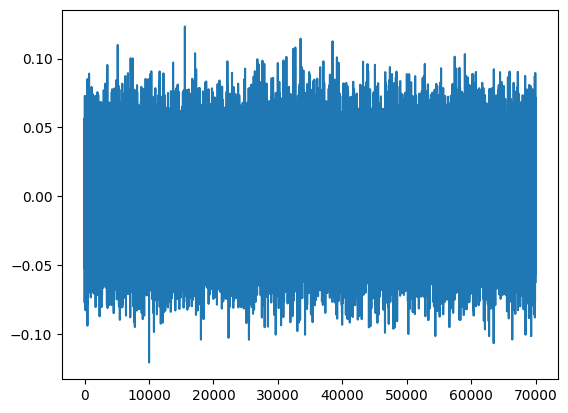

In [9]:
plt.plot(coherence_data[19])

In [10]:
win_len = 1
overlap = 0
samples_per_sec = 1000

t0 = time.time()
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    coherence_data, win_len, overlap, sample_interval=1 / samples_per_sec
)
t1 = time.time()
common_time = t1 - t0

welch_coherence_mat = np.matmul(
    norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0, 2, 1))
)
coherence = np.absolute(welch_coherence_mat) ** 2

norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
    noise, win_len, overlap, sample_interval=1 / samples_per_sec
)
welch_coherence_mat_noise = np.matmul(
    norm_win_spectra_noise,
    np.conjugate(norm_win_spectra_noise.transpose(0, 2, 1)),
)
coherence_noise = np.absolute(welch_coherence_mat_noise) ** 2

In [11]:
t0 = time.time()
preprocessed_data = f.covariance_preprocessing(coherence_data, sample_interval=1/samples_per_sec)
win_spectra, frequencies = f.windowed_spectra(
    preprocessed_data,
    win_len,
    overlap,
    freq=None,
    sample_interval=1/samples_per_sec,
)
win_spectra = win_spectra.transpose(2, 1, 0)

t1 = time.time()
covariance_time = t1 - t0

norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
    noise, win_len, overlap, sample_interval=1 / samples_per_sec
)

preprocessed_data_noise = f.covariance_preprocessing(noise, sample_interval=1/samples_per_sec)
win_spectra_noise, frequencies = f.windowed_spectra(
    preprocessed_data_noise,
    win_len,
    overlap,
    freq=None,
    sample_interval=1/samples_per_sec,
)
win_spectra_noise = win_spectra_noise.transpose(2, 1, 0)

num_frames = win_spectra_noise.shape[0]
eig_ratios_covariance = np.empty(num_frames)
eig_ratios_covariance_noise = np.empty(num_frames)

for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
            win_spectra[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_covariance[d] = np.max(svd_approx2) / np.sum(svd_approx2)
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
            win_spectra_noise[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_covariance_noise[d] = np.max(svd_approx2) / np.sum(svd_approx2)


In [18]:
noise_factors = [0, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]
num_frames = win_spectra_noise.shape[0]
eig_ratios_covariance = np.empty((len(noise_factors), num_frames))
eig_ratios_covariance_noise = np.empty((len(noise_factors), num_frames))

eig_ratios_coherence = np.empty((len(noise_factors), num_frames))
eig_ratios_coherence_noise = np.empty((len(noise_factors), num_frames))

eig_ratios_coherence_qr = np.empty((len(noise_factors), num_frames))
eig_ratios_coherence_noise_qr = np.empty((len(noise_factors), num_frames))

nf = 0
nr, nc = data.shape
noise = np.random.normal(scale=1, size=(nr, nc))
# normalize noise
noise_base = noise / np.linalg.norm(noise)

for noise_factor in noise_factors:
    # coherence_data = receiver_amplitudes[0].cpu().numpy()
    noise = noise_base * np.max(np.abs(coherence_data)) * noise_factor
    coherence_data = data + noise

    preprocessed_data = f.covariance_preprocessing(coherence_data, sample_interval=1/samples_per_sec)
    win_spectra, frequencies = f.windowed_spectra(
        preprocessed_data,
        win_len,
        overlap,
        freq=None,
        sample_interval=1/samples_per_sec,
    )
    win_spectra = win_spectra.transpose(2, 1, 0)

    preprocessed_data_noise = f.covariance_preprocessing(noise, sample_interval=1/samples_per_sec)
    win_spectra_noise, frequencies = f.windowed_spectra(
        preprocessed_data_noise,
        win_len,
        overlap,
        freq=None,
        sample_interval=1/samples_per_sec,
    )
    win_spectra_noise = win_spectra_noise.transpose(2, 1, 0)

    norm_win_spectra, frequencies = f.normalised_windowed_spectra(
        coherence_data, win_len, overlap, sample_interval=1 / samples_per_sec
    )

    norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
        noise, win_len, overlap, sample_interval=1 / samples_per_sec
    )

    for d in range(1,num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
        S = np.linalg.svd(
                win_spectra[d],
                compute_uv=False,
                hermitian=False,
            )
        svd_approx2 = S**2
        # svd_approx2 = np.sort(S)[::-1]**2
        eig_ratios_covariance[nf, d] = np.max(svd_approx2) / np.sum(svd_approx2)

        # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
        S = np.linalg.svd(
                win_spectra_noise[d],
                compute_uv=False,
                hermitian=False,
            )
        svd_approx2 = S**2
        # svd_approx2 = np.sort(S)[::-1]**2
        eig_ratios_covariance_noise[nf, d] = np.max(svd_approx2) / np.sum(svd_approx2)


    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
        S = np.linalg.svd(
                norm_win_spectra[d],
                compute_uv=False,
                hermitian=False,
            )
        svd_approx2 = S**2
        # svd_approx2 = np.sort(S)[::-1]**2
        eig_ratios_coherence[nf, d] = np.max(svd_approx2) / np.sum(svd_approx2)

        # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
        S = np.linalg.svd(
                norm_win_spectra_noise[d],
                compute_uv=False,
                hermitian=False,
            )
        svd_approx2 = S**2
        # svd_approx2 = np.sort(S)[::-1]**2
        eig_ratios_coherence_noise[nf, d] = np.max(svd_approx2) / np.sum(svd_approx2)


        Q, R = np.linalg.qr(norm_win_spectra[d])
        RRH = R @ (np.matrix(R).H)
        # diag is of sqrt(RR^*)
        qr_approx2 = np.power(np.diag(RRH), 0.5)
        eig_ratios_coherence_qr[nf, d] = np.max(qr_approx2) / np.sum(qr_approx2)

        Q, R = np.linalg.qr(norm_win_spectra_noise[d])
        RRH = R @ (np.matrix(R).H)
        # diag is of sqrt(RR^*)
        qr_approx2 = np.power(np.diag(RRH), 0.5)
        eig_ratios_coherence_noise_qr[nf, d] = np.max(qr_approx2) / np.sum(qr_approx2)

    nf += 1

d:\CSM\Mines_Research\Repositories\Coherence_Analyses\notebooks\..\coherence_analysis\utils.py:298: RuntimeWarning: invalid value encountered in divide
  spectral_whitened = data_fft / running_avg
d:\CSM\Mines_Research\Repositories\Coherence_Analyses\notebooks\..\coherence_analysis\utils.py:150: RuntimeWarning: invalid value encountered in divide
  normalized_spectra = win_spectra.transpose(2, 1, 0) / normalizer


LinAlgError: SVD did not converge

Text(0.5, 1.0, 'Covariance eigenvalue ratio')

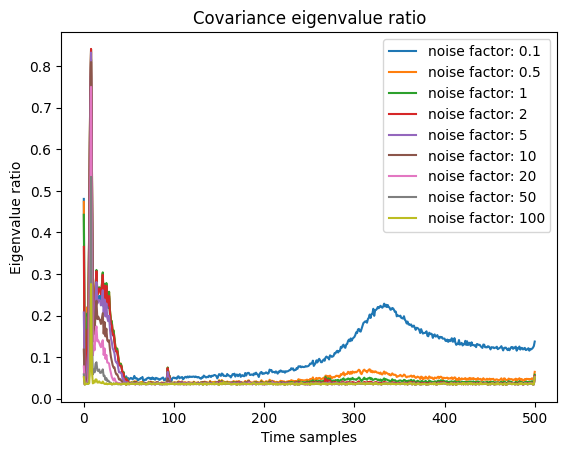

In [ ]:
for nf in range(len(noise_factors)):
    plt.plot(eig_ratios_covariance[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Time samples")
plt.ylabel("Eigenvalue ratio")
plt.title("Covariance eigenvalue ratio")

Text(0.5, 1.0, 'Coherence eigenvalue ratio')

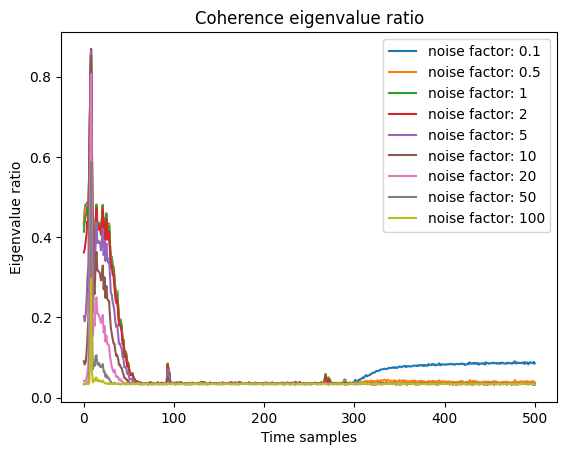

In [14]:
for nf in range(len(noise_factors)):
    plt.plot(eig_ratios_coherence[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Time samples")
plt.ylabel("Eigenvalue ratio")
plt.title("Coherence eigenvalue ratio")

Text(0.5, 1.0, 'Coherence eigenvalue ratio')

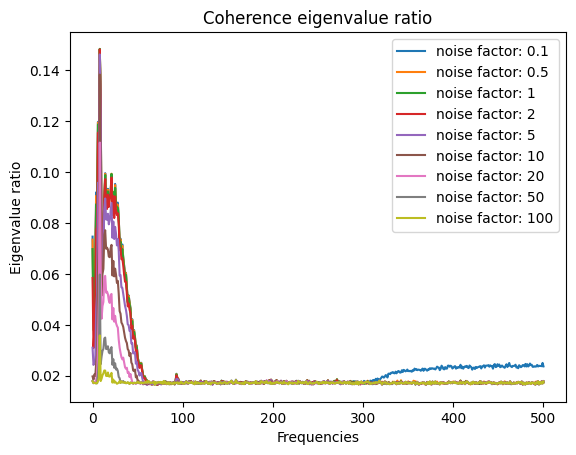

In [15]:
for nf in range(len(noise_factors)):
    plt.plot(eig_ratios_coherence_qr[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Frequencies")
plt.ylabel("Eigenvalue ratio")
plt.title("Coherence eigenvalue ratio")

Text(0.5, 1.0, 'Relative error')

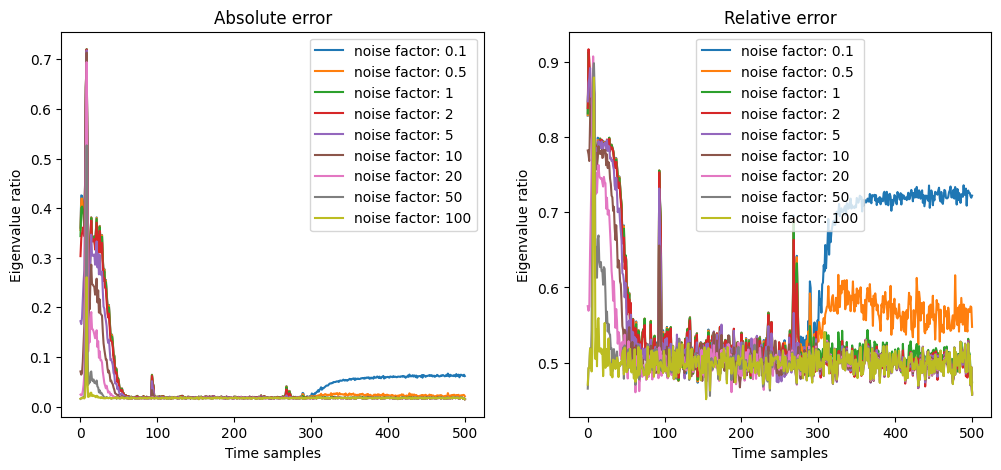

In [16]:
absolute_errors = np.abs(eig_ratios_coherence - eig_ratios_coherence_qr)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for nf in range(len(noise_factors)):
    plt.plot(absolute_errors[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Time samples")
plt.ylabel("Eigenvalue ratio")
plt.title("Absolute error")
plt.subplot(1, 2, 2)
relative_errors = absolute_errors / eig_ratios_coherence
for nf in range(len(noise_factors)):
    plt.plot(relative_errors[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Time samples")
plt.ylabel("Eigenvalue ratio")
plt.title("Relative error")